In [5]:
import geopandas as gpd
import rasterio
import pandas as pd
from rasterio.mask import mask
import numpy as np
from rasterio.enums import Resampling 
import matplotlib.pyplot as plt



In [6]:
raster = rasterio.open("data\elevation\\be15_grd\w001000.adf")

<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\wassim\AppData\Local\Temp\ipykernel_34376\713298894.py:1: SyntaxWarning: invalid escape sequence '\e'
  raster = rasterio.open("data\elevation\\be15_grd\w001000.adf")


In [3]:
dz = gpd.read_file("data\landcover\dz\dza_gc_adg.shp")
tn = gpd.read_file("data\landcover\\tn\\tun_gc_adg.shp")

combined = gpd.GeoDataFrame(pd.concat([dz, tn], ignore_index=True))

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\wassim\AppData\Local\Temp\ipykernel_34376\4048785983.py:1: SyntaxWarning: invalid escape sequence '\l'
  dz = gpd.read_file("data\landcover\dz\dza_gc_adg.shp")
C:\Users\wassim\AppData\Local\Temp\ipykernel_34376\4048785983.py:2: SyntaxWarning: invalid escape sequence '\l'
  tn = gpd.read_file("data\landcover\\tn\\tun_gc_adg.shp")


Original shape: 33600 x 86400
Downsampled shape: (3360, 8640)


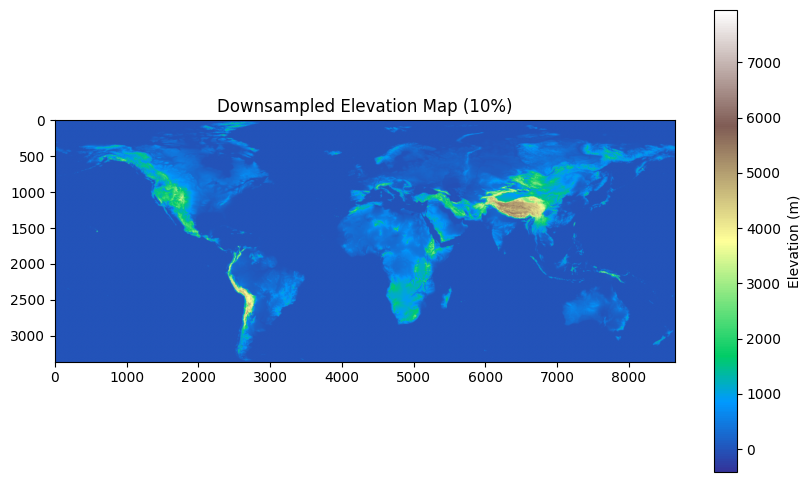

In [8]:

# Path to the folder (the folder itself is the "dataset")
raster_file = "data/elevation/be15_grd/w001000.adf"


with rasterio.open(raster_file) as src:
    print("Original shape:", src.height, "x", src.width)
    scale = 0.1
    new_height = int(src.height * scale)
    new_width = int(src.width * scale)
    elevation = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.average
    )
    transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )

print("Downsampled shape:", elevation.shape)
plt.figure(figsize=(10, 6))
plt.imshow(elevation, cmap="terrain")
plt.colorbar(label="Elevation (m)")
plt.title("Downsampled Elevation Map (10%)")
plt.show()



In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# -----------------------------
# Paths
# -----------------------------
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
raster_path = "data/elevation/be15_grd/w001000.adf"

# -----------------------------
# Load country shapes
# -----------------------------
# world = gpd.read_file(shapefile_path).to_crs("EPSG:4326")
# world["ADMIN"] = world["ADMIN"].str.strip().str.lower()

algeria = combined

if algeria.empty :
    raise ValueError("Could not find Algeria or Tunisia in the shapefile.")

# -----------------------------
# Clip raster function
# -----------------------------
def clip_raster(raster_path, country_gdf):
    with rasterio.open(raster_path) as src:
        country_geom = [country_gdf.geometry.unary_union] # Merge all geometries
        # Mask only the country area to save memory
        clipped_image, clipped_transform = mask(src, country_geom, crop=True)
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "height": clipped_image.shape[1],
            "width": clipped_image.shape[2],
            "transform": clipped_transform
        })
    return clipped_image[0], clipped_meta

# -----------------------------
# Memory-safe clipping
# -----------------------------
algeria_clip, _ = clip_raster(raster_path, algeria)

# -----------------------------
# Use original raster's global min/max for consistent colors
# -----------------------------
with rasterio.open(raster_path) as src:
    # Read in a downsampled version to get min/max without MemoryError
    print(src.meta) 
    factor = 10  # downsample factor for stats
    out_shape = (1, src.height // factor, src.width // factor)
    data_small = src.read(1, out_shape=out_shape, masked=True)
    global_min = data_small.min()
    global_max = data_small.max()
    nodata = src.nodata



norm = Normalize(vmin=global_min, vmax=global_max)

# -----------------------------
# Plot function
# -----------------------------
def plot_raster(data, title):
    plt.figure(figsize=(6,6))
    plt.imshow(data, cmap= "terrain" , norm=norm)
    plt.title(title, fontsize=13)
    plt.colorbar(label="Elevation (m)")
    plt.axis("off")
    plt.show()

# -----------------------------
# Plot clipped maps
# -----------------------------
plot_raster(algeria_clip, "GMTED2010 Elevation — Algeria")



DataSourceError: ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp: No such file or directory